# Model

In this script we are buildin the model using part of single-cell data and test with bulk data. For sake of time, and computation limitation with selected only 22 genes to build the model. The selection of these genes, or feature selection, results from finding the genes that have higher differential expression found in the analysis of single-cell-RNA data.

In Google Colab set the runtine as: ==R with TPU==; running it without TPU resulted in errors (possibly solved with "reticulate" package, code commented).

File(s) needed: 
    - 'bulk_tissue_data.csv' from notebook `01scripts\01_compBiology_bulk.ipynb`;
    - 'sc-RNAseq_genes_input_22.csv' & `sc_RNAseq_output_patients.csv` from notebook  `01scripts\02_comBiology_singleCell.ipynb`

## load libraries and functions

In [ ]:
# libraries ####
devtools::install_github("rstudio/keras")
install.packages("tidyverse")
install.packages("gradDescent")
library(keras)
library(tidyverse)
#library(gradDescent)

## custom functions ####
# create a function to generate mock data about the proportion of each cell type. For this the sum of the is 1
# with this function with can specify the mock number of cell type by the `n_rows` and the number of samples as `n_cols`

create_matrix <- function(n_rows, n_cols) {
  # Generate a vector of random numbers between 0 and 1
  data <- runif(n_rows * n_cols)

  # Create a matrix from the vector
  matrix <- matrix(data, nrow = n_rows, ncol = n_cols)

# Normalize the matrix such that the sum of each column is 1
  for (i in 1:n_cols) {
    matrix[, i] <- matrix[, i] / sum(matrix[, i])
  }

  return(matrix)
}

# as alternative scaling function --- NOT USED
min_max_scaling <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}

Skipping install of 'keras' from a github remote, the SHA1 (d8c9e28e) has not changed since last install.
  Use `force = TRUE` to force installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# load data

In [1]:
# load data ####
tissue_pseudobulk_data <- read.csv("sc-RNAseq_genes_input_22.csv")
data <- tissue_pseudobulk_data #[c(1:5,c(17276:17279)),1:5]
tail(data)
## preprocess data --- scale ####
split_gene_features <- data[c(1:22),-1]
tail(split_gene_features)


,ENSEMBL,avg,datos...2.,datos...2..1,datos...2..2,datos...2..3,datos...2..4,datos...2..5,datos...2..6,datos...2..7,datos...2..8,datos...2..9,datos...2..10,datos...2..11,datos...2..12,datos...2..13
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,ENSG00000110436,5.852076,3.649435,4.642402,3.996960,3.996960,3.676506,4.258524,4.782977,4.987370,4.988927,5.010840,3.4614782,4.578959,5.816827,5.417718
20,ENSG00000155886,4.150416,3.252994,4.396201,3.496597,3.496597,4.026074,3.825967,4.144374,4.367679,3.707022,4.504819,3.6269233,4.633240,4.931287,4.932010
21,ENSG00000147488,4.761013,3.035550,4.993605,3.426055,3.426055,4.238830,4.131735,5.054408,4.836034,3.923564,4.835064,3.3134912,4.821044,5.122124,5.228724
22,ENSG00000073849,4.621935,2.164332,3.983863,2.059301,2.059301,1.761852,3.486348,4.755170,4.418591,4.513338,4.172094,0.7141367,4.363391,4.618421,4.270036
23,sex,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0000000,0.000000,1.000000,1.000000
24,condition,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0000000,0.000000,0.000000,0.000000


,avg,datos...2.,datos...2..1,datos...2..2,datos...2..3,datos...2..4,datos...2..5,datos...2..6,datos...2..7,datos...2..8,datos...2..9,datos...2..10,datos...2..11,datos...2..12,datos...2..13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17,4.561187,3.310800,4.664368,3.089309,3.089309,4.065858,3.692696,4.690381,4.426384,3.588523,4.246935,3.8631913,4.459028,4.432549,4.265383
18,2.920038,3.379806,3.479461,3.579110,3.579110,3.284708,3.853253,4.519868,3.791683,4.482599,3.538597,2.9243317,4.525882,3.777117,4.016649
19,5.852076,3.649435,4.642402,3.996960,3.996960,3.676506,4.258524,4.782977,4.987370,4.988927,5.010840,3.4614782,4.578959,5.816827,5.417718
20,4.150416,3.252994,4.396201,3.496597,3.496597,4.026074,3.825967,4.144374,4.367679,3.707022,4.504819,3.6269233,4.633240,4.931287,4.932010
21,4.761013,3.035550,4.993605,3.426055,3.426055,4.238830,4.131735,5.054408,4.836034,3.923564,4.835064,3.3134912,4.821044,5.122124,5.228724
22,4.621935,2.164332,3.983863,2.059301,2.059301,1.761852,3.486348,4.755170,4.418591,4.513338,4.172094,0.7141367,4.363391,4.618421,4.270036


In [2]:
### convert to binary
dim(data)
binary_sex <- (data[23,-1])
binary_condition <- (data[24,-1])
binary_sex


[1] 24 16

,avg,datos...2.,datos...2..1,datos...2..2,datos...2..3,datos...2..4,datos...2..5,datos...2..6,datos...2..7,datos...2..8,datos...2..9,datos...2..10,datos...2..11,datos...2..12,datos...2..13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1


In [3]:
scale_genes <- t(scale(t(data.matrix(split_gene_features))))
#scale_genes <- sapply(t(data.matrix(split_gene_features)),min_max_scaling)
# (colnames(split_gene_features) == colnames(binary_sex) ) == colnames(binary_condition)
head(scale_genes)
x_original <- rbind(scale_genes,binary_sex,binary_condition)

,avg,datos...2.,datos...2..1,datos...2..2,datos...2..3,datos...2..4,datos...2..5,datos...2..6,datos...2..7,datos...2..8,datos...2..9,datos...2..10,datos...2..11,datos...2..12,datos...2..13
1,0.6648486,-1.02251763,0.770839681,-0.9267966,-0.9267966,-0.8750437,-0.7855671,0.2577404,0.6038839,-0.2089741,0.8388159,-1.8249945,0.6478873,1.3386027,1.4480716
2,1.3071451,0.11443569,-0.247522210,-0.6892695,-0.6892695,-2.0893628,-0.9154077,0.7282029,1.1389475,0.5629869,0.5512892,-1.5450812,0.8097351,0.2489209,0.7142496
3,-1.5744723,-0.07180996,-0.929278238,1.3729978,1.3729978,1.1626495,0.1423393,-2.1367872,0.2843948,0.7032444,-0.1567757,-0.2167671,-0.2793158,-0.1246820,0.4512646
4,-0.8819106,-0.79191744,0.963667571,-0.5117070,-0.5117070,-1.0656170,-1.0680300,-1.0691951,0.9924874,1.4824340,0.6924434,-0.9582678,1.4959204,0.8868126,0.3445867
5,0.3689417,-1.70804627,0.008318614,-1.1679330,-1.1679330,-0.5758376,-0.4494701,0.6667245,1.1128021,-0.5760530,0.4912346,-0.7883718,1.1201626,1.3349918,1.3304689
6,1.0603816,-2.05156964,-0.204237013,-1.1727669,-1.1727669,-0.1143000,-0.4958516,0.6799389,0.9562644,-0.3256429,0.4159400,-0.7488612,0.9397562,1.0149787,1.2187362


In [4]:
tail(x_original)

,avg,datos...2.,datos...2..1,datos...2..2,datos...2..3,datos...2..4,datos...2..5,datos...2..6,datos...2..7,datos...2..8,datos...2..9,datos...2..10,datos...2..11,datos...2..12,datos...2..13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,1.6338821,-1.2585951,0.04535418,-0.8022305,-0.8022305,-1.2230467,-0.45874809,0.22995643,0.4983615,0.5004067,0.5291823,-1.5054177,-0.03795722,1.5875935,1.0634891
20,0.0965085,-1.6038467,0.56220084,-1.1422886,-1.1422886,-0.1390838,-0.51822803,0.08506131,0.5081584,-0.7435944,0.7680008,-0.8953584,1.01132088,1.5760339,1.5774040
21,0.5565564,-1.7416249,0.86635116,-1.2215031,-1.2215031,-0.1389501,-0.28159218,0.94733575,0.6564788,-0.5588602,0.6551872,-1.3714287,0.63651301,1.0375285,1.1795114
22,0.8720433,-0.9790075,0.39145135,-1.0581162,-1.0581162,-1.2821527,0.01672662,0.97239496,0.7188855,0.7902491,0.5332257,-2.0712851,0.67730956,0.8693963,0.6069954
23,1.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,1.0000000,1.0000000,0.00000000,1.0000000,1.0000000
24,0.0000000,1.0000000,0.00000000,1.0000000,1.0000000,1.0000000,1.00000000,0.00000000,0.0000000,1.0000000,0.0000000,1.0000000,0.00000000,0.0000000,0.0000000


In [6]:
# Create a matrix with random numbers
number_of_cell_types = 3
number_of_samples = dim(x_original)[2] # number of patients
y_original <- read.csv("sc_RNAseq_output_patients.csv")
y_original <- y_original[c(1:3), -1]
# Normalize the columns to sum to 1
#y_original <- y_original / colSums(y_original)

In [ ]:
y_original

,Freq,Freq2,Freq3,Freq4,Freq5,Freq6,Freq7,Freq8,Freq9,Freq10,Freq11,Freq12,Freq13,Freq14,Freq15
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.08363636,0.13023873,0.009746589,0.08972822,0.22585837,0.3256,0.14626289,0.1621212,0.1770509,0.13159815,0.1502008,0.3511864,0.1694967,0.1459706,0.4102564
2,0.05200000,0.05517241,0.200779727,0.02977618,0.07993562,0.0432,0.09310567,0.1174242,0.1173416,0.09705668,0.1078313,0.3396610,0.1276531,0.1221490,0.1623932
3,0.86436364,0.81458886,0.789473684,0.88049560,0.69420601,0.6312,0.76063144,0.7204545,0.7056075,0.77134517,0.7419679,0.3091525,0.7028502,0.7318804,0.4273504


In [7]:
# build the model ####
x <- x_original
y <- y_original
tissue_composition <- dim(y)[1]
number_of_features <- dim(x)[1]
dim(x)
dim(y)
tissue_composition

[1] 24 15

[1]  3 15

[1] 3

In [8]:
# Assuming you have a dataset 'data' with features 'x' and labels 'y'
x <- t(x)
y <- t(y)
# Set a random seed for reproducibility
set.seed(123)

# Define the proportion of data to use for testing (e.g., 20%)
test_split_ratio <- 0.2

# Generate random indices for splitting the data
num_samples <- nrow(x)
num_test_samples <- round(num_samples * test_split_ratio)
test_indices <- sample(1:num_samples, num_test_samples)

# Split the data into training and test sets
x_train <- x[-test_indices, ]  # Training features
y_train <- y[-test_indices, ]  # Training labels
x_test <- x[test_indices, ]    # Test features
y_test <- y[test_indices, ]    # Test labels

# Now you have x_train, y_train for training, and x_test, y_test for testing

In [9]:
test_indices

[1] 15  3 14

In [10]:

# Initialize model
model <- keras_model_sequential()


ERROR: Error in keras_model_sequential(): could not find function "keras_model_sequential"


In [ ]:
dim(x_original)[1]

[1] 24

In [ ]:
# Add layers
feature_factor = 1
feacture_factor2 = 0.5
model %>%
  layer_dense(units = feature_factor*number_of_features, activation = 'sigmoid', input_shape = dim(x)[2]) %>% # units=265 relu
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = number_of_features, activation = 'sigmoid') %>% #units = 128 relu
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = tissue_composition, activation = 'softmax')


In [ ]:
# Compile model
model %>% compile(
  loss = 'categorical_crossentropy', # binary_crossentropy #
  optimizer = optimizer_rmsprop(),#optimizer_rmsprop(),
  metrics = c('accuracy')
)


In [ ]:
# Train model
history <- model %>% fit(
  x_train,
  y_train,
  epochs = 30,
  batch_size = 4,
)

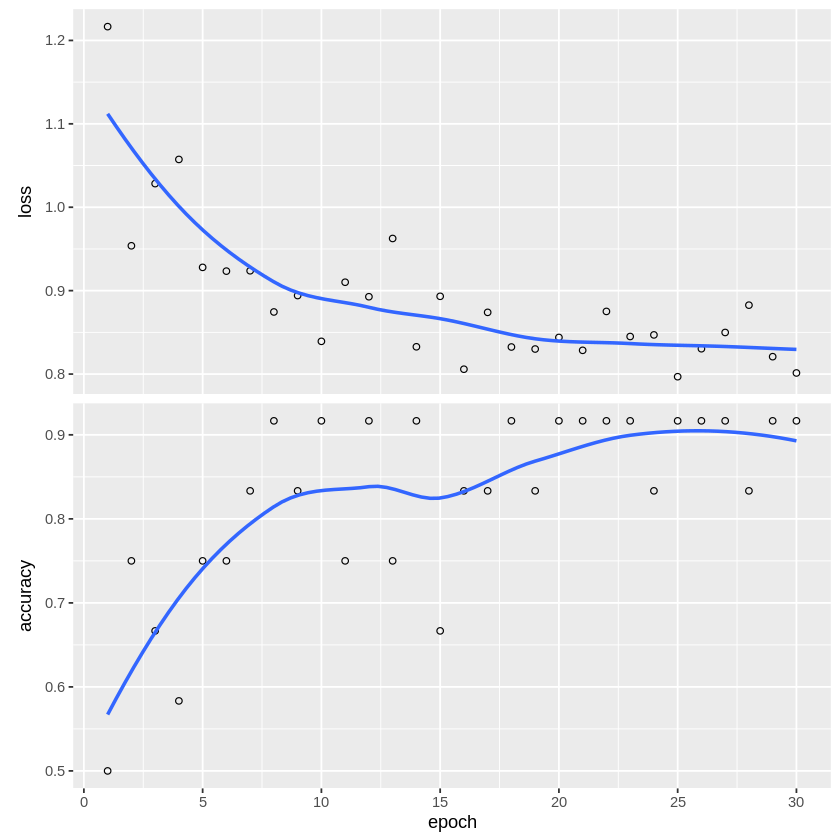

In [ ]:
plot(history)

In [ ]:
# Evaluate model
model %>% evaluate(x_test,y_test)

loss  accuracy 
0.9063619 1.0000000

In [ ]:
# Make predictions
#out put layer (softmax vector)
predictions = model %>% predict(x_test)
head(predictions)
head(model %>% predict(x_test)) %>% apply(1, sum)

0.09556587,0.02498088,0.8794533
0.11851319,0.00333549,0.8781513
0.07996369,0.02795538,0.8920809


[1] 1 1 1

In [ ]:
head(y_test)
head(y_test %>% apply(1, sum))

,1,2,3
Freq15,0.410256410,0.1623932,0.4273504
Freq3,0.009746589,0.2007797,0.7894737
Freq14,0.145970603,0.1221490,0.7318804


Freq15  Freq3 Freq14 
     1      1      1

In [ ]:
head(x_test[,1:2])

,1,2
datos...2..13,1.4480716,0.7142496
datos...2..1,0.7708397,-0.2475222
datos...2..12,1.3386027,0.2489209


# Predict bulk data

In [13]:
# process and prepare bulk for pipeline
data_bulk <- read.csv("bulk_tissue_data.csv")
genes_in_singleCell <- tissue_pseudobulk_data$ENSEMBL[1:22]
genes_filter_bulk <- data_bulk %>% filter(ensembl_gene_id %in% genes_in_singleCell)
matched_gene_order_bulk <- genes_filter_bulk %>% arrange(match(ensembl_gene_id,genes_in_singleCell))
# remove ensembl
split_gene_features <- matched_gene_order_bulk[,-1]
### convert to binary
binary_sex <- ifelse(data_bulk[17276,] == "F", 1, 0)[,-1]
binary_condition <- ifelse( data_bulk[17279,] == "control", 0, 1)[,-1]

# scale
scale_genes <- t(scale(t(data.matrix(split_gene_features))))
head(scale_genes)
head(binary_sex)
head(binary_condition)
bulk_genes_filtered <- rbind(scale_genes,binary_sex,binary_condition)
bulk_genes_filtered
x_test_bulk <- bulk_genes_filtered

GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,GSM86796,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
-0.37928314,-1.7504326,-1.4762027,-1.7504326,-0.1050532,-0.92774293,-0.6535130,-0.6535130,0.71763644,-0.9277429,...,0.7176364,0.9918663,0.99186634,1.2660962,1.2660962,0.9918663,0.1691767,0.7176364,1.8145560,0.1691767
0.89745626,1.4941113,1.0963413,0.8974563,0.1019162,0.69857125,0.4996862,0.1019162,0.69857125,0.8974563,...,-0.2958538,-0.8925089,0.30080122,-1.0913939,-1.0913939,-0.4947388,-0.8925089,0.6985712,0.6985712,-0.6936239
1.43145599,0.2665869,1.4314560,1.1984822,0.9655084,0.96550837,0.4995608,0.9655084,0.96550837,-0.4323345,...,-0.4323345,-0.8982821,-1.83017733,-2.5290988,-1.8301773,-1.1312559,-0.1993607,-0.8982821,-0.4323345,-0.1993607
1.03730290,0.2451377,-0.3885945,1.6710351,-0.2301614,0.08670465,-0.5470275,-0.7054606,0.87886985,1.3541690,...,-0.5470275,-1.1807597,-0.54702752,0.8788699,1.9879011,-1.3391927,-0.2301614,-0.7054606,-0.3885945,1.8294681
-1.34374283,0.9758905,0.5409593,-1.4887199,-1.6336970,0.83091344,0.9758905,0.5409593,-1.05378866,0.8309134,...,0.3959822,-0.1839262,0.39598219,0.3959822,0.6859364,1.2658447,-1.7786741,0.6859364,-1.3437428,1.2658447
0.03314604,-0.8921809,1.6987346,-1.8175079,-0.8921809,-1.44737714,2.0688654,2.0688654,0.03314604,-1.2623117,...,0.2182114,-0.1519194,0.03314604,-0.7071155,-0.7071155,0.9584730,0.9584730,-0.1519194,1.3286038,-0.3369848


GSM86787 GSM86788 GSM86789 GSM86790 GSM86791 GSM86792 
       0        0        0        0        0        0

GSM86787 GSM86788 GSM86789 GSM86790 GSM86791 GSM86792 
       1        1        1        1        1        1

,GSM86787,GSM86788,GSM86789,GSM86790,GSM86791,GSM86792,GSM86793,GSM86794,GSM86795,GSM86796,...,GSM87114,GSM87115,GSM87116,GSM87117,GSM87118,GSM87119,GSM87120,GSM87121,GSM87122,GSM87123
,-0.37928314,-1.7504326,-1.47620272,-1.75043261,-0.10505324,-0.92774293,-0.65351303,-0.65351303,0.71763644,-0.92774293,...,0.71763644,0.99186634,0.99186634,1.26609623,1.26609623,0.99186634,0.16917665,0.7176364,1.81455602,0.1691767
,0.89745626,1.4941113,1.09634128,0.89745626,0.10191620,0.69857125,0.49968623,0.10191620,0.69857125,0.89745626,...,-0.29585383,-0.89250888,0.30080122,-1.09139389,-1.09139389,-0.49473884,-0.89250888,0.6985712,0.69857125,-0.6936239
,1.43145599,0.2665869,1.43145599,1.19848218,0.96550837,0.96550837,0.49956075,0.96550837,0.96550837,-0.43233448,...,-0.43233448,-0.89828210,-1.83017733,-2.52909876,-1.83017733,-1.13125591,-0.19936067,-0.8982821,-0.43233448,-0.1993607
,1.03730290,0.2451377,-0.38859447,1.67103506,-0.23016143,0.08670465,-0.54702752,-0.70546056,0.87886985,1.35416898,...,-0.54702752,-1.18075968,-0.54702752,0.87886985,1.98790114,-1.33919272,-0.23016143,-0.7054606,-0.38859447,1.8294681
,-1.34374283,0.9758905,0.54095927,-1.48871991,-1.63369700,0.83091344,0.97589052,0.54095927,-1.05378866,0.83091344,...,0.39598219,-0.18392615,0.39598219,0.39598219,0.68593635,1.26584469,-1.77867408,0.6859364,-1.34374283,1.2658447
,0.03314604,-0.8921809,1.69873462,-1.81750793,-0.89218095,-1.44737714,2.06886541,2.06886541,0.03314604,-1.26231174,...,0.21821144,-0.15191936,0.03314604,-0.70711555,-0.70711555,0.95847303,0.95847303,-0.1519194,1.32860382,-0.3369848
,-1.25010548,0.4450298,0.18423973,-0.98931544,-0.98931544,-1.38050050,-1.38050050,-1.11971046,-0.98931544,1.22739988,...,0.96660984,1.09700486,-0.33734035,0.70581980,0.05384471,0.18423973,1.35779490,1.2273999,1.35779490,-1.3805005
,0.10202855,1.3749227,-0.74656756,0.95062467,-0.88800024,-0.88800024,-0.18083682,-0.32226950,-0.60513487,-0.88800024,...,-1.31229830,0.52632661,-1.31229830,1.37492272,-1.45373099,-1.31229830,1.09205735,-0.6051349,-0.03940413,-0.8880002
,-0.02404077,-0.9026216,-0.24368597,3.70992763,-0.46333117,-0.68297637,-0.24368597,0.19560443,-0.46333117,-0.46333117,...,-0.02404077,-0.24368597,-0.02404077,-0.68297637,-0.46333117,-0.02404077,-0.24368597,-0.4633312,0.19560443,-0.2436860
,-0.88979465,-1.0284371,-0.88979465,-0.61250980,1.46712652,-0.75115223,-1.02843707,-1.02843707,-0.19658254,-0.33522496,...,1.46712652,1.32848410,1.32848410,0.63527199,1.46712652,0.21934473,1.18984168,1.3284841,1.05119926,1.1898417


In [14]:
length(genes_in_singleCell)

[1] 22

In [15]:
dim(t(x_test_bulk))

[1] 201  24

In [ ]:
# Make predictions
#out put layer (softmax vector)
predictions_bulk = model %>% predict(t(x_test_bulk))
head(predictions_bulk)
head(model %>% predict(x_test)) %>% apply(1, sum)

1.095216e-01,0.024541663,0.8659368
7.346684e-01,0.006783348,0.2585483
1.267710e-01,0.087875210,0.7853538
4.840095e-05,0.001314245,0.9986374
1.603355e-01,0.004203341,0.8354611
7.977182e-02,0.040516354,0.8797118


[1] 1 1 1

# conclusions

In less than two weeks we have built the base architecture of a machine learning model to predic tissue composition based on gene expression profiles. 
Naturally, our model requires further training and validation, especially including more features, besides the selected 22 genes. However, we think that considering all the genes might introduced noise, thus the idea would be to improve feature selection. For example, considering genes that are described to be associated with Huntington's_disease as well as markers of specific cell types in the brain. 